In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame
from MyLearner import MyLearner
from MyScorer import MyScorer
from MyPlotter import MyPlotter
import pandas as pd
import numpy as np
# from sympy.combinatorics.graycode import GrayCode
import math
import scipy.stats as sts
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn.metrics as metrics
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
# from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import label_binarize, Normalizer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.multiclass import OneVsOneClassifier as ovo
from sklearn.multiclass import OutputCodeClassifier as occ
# from sklearn.preprocessing import MultiLabelBinarizer
import sklearn
import sklearn.metrics as metrics
from rfpimp import dropcol_importances
from rfpimp import permutation_importances
import imblearn.over_sampling as imbOVS

from dabl.plot import class_hists

# from collections.abc import Sequence
# from itertools import chain

# from scipy.sparse import issparse
# from scipy.sparse.base import spmatrix
# from scipy.sparse import dok_matrix
# from scipy.sparse import lil_matrix
# from sklearn.utils.validation import check_array, _assert_all_finite

# print(sklearn.__version__)

c:\00_data\python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Analysis

The Titanic dataset is naturaly a passenger manifest and provides just a basic information about each passanger and information about their tickets.
Also, there are two columns 'SibSp' and 'Parch' that give information about passanger's family. It's interestiong though, have there been these columns in the real manifest..?

#### Well, here is the official descriotion of the dataset:
(see [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data))

### Importing data

In [2]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

### Training Set

In [3]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### First, lets remember the Titanic strory 
(see [wikipedia](https://en.wikipedia.org/wiki/RMS_Titanic)).

After leaving Southampton on 10 April 1912, Titanic called at Cherbourg in France and Queenstown (now Cobh) in Ireland, before heading west to New York.
On 14 April, four days into the crossing and about 375 miles (600 km) south of Newfoundland, she hit an iceberg at 11:40 p.m. ship's time. The collision caused the hull plates to buckle inwards along her starboard (right) side and opened five of her sixteen watertight compartments to the sea; she could only survive four flooding. Meanwhile, passengers and some crew members were evacuated in lifeboats, many of which were launched only partially loaded. A disproportionate number of men were left aboard because of a "women and children first" protocol for loading lifeboats.[8] At 2:20 a.m., she broke apart and foundered with well over one thousand people still aboard. Just under two hours after Titanic sank, the Cunard liner RMS Carpathia arrived and brought aboard an estimated 705 survivors.

Ok, lets note something.

**"After leaving Southampton on 10 April 1912, Titanic called at Cherbourg in France and Queenstown (now Cobh) in Ireland"**
1. Southampton ('S') - departure (England)
2. Cherbourg ('C') - France
3. Queenstown ('Q') - Ireland

First, i believe that the most of the first class boarded in Southampton. Why? Because its England! lol

Second, The most of the third class I think boarded in Ireland. Why? Because british were rich and many had a busines in US, while irish were poor immigrants.

*I don't actually know yet will I need this information at all, but lets keep it for now.
   
**"...she hit an iceberg at 11:40 p.m. ship's time"**
* The most people were probably not slipping and were somewhere outside their cabins...
    
**"...passengers and some crew members...in lifeboats, many of which were launched only partially loaded" and "disproportionate number of men were left aboard because of a "women and children first" protocol"**
* This clearly says that most of the survivals vere women and children.

#### Conclusions
1. Women were likely to survive ('Sex' definitely matters!)
2. Children were likely to survive ('Age' definitely matters!)
3. 1-st class passengers were probaly likely to survive (were on upper decks, got information first, got to lifeboats first) ('Pclass' is probably matters)

Now lets look at numbers!



### Checking missing values

In [4]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,177
Cabin,687
Embarked,2


Seems to be a lot of missing values in 'Age' and 'Cabin'.

Lets calculate percentage.

In [5]:
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls


,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

#### Calculate survival rate

In [6]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

In [7]:
#prepare data for plots
target = 'Survived'
features = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

In [8]:
#preparing data for classification for missing values of 'Embarked'.
# df = data_train.drop(columns=['Survived', 'Age'])
# df1 = df.loc[:, ['Pclass', 'Sex', 'SibSp', '', '', '']]

#removing lines with missing values
data = data_train[data_train['Embarked'].notna()]
# df

data_num = data[['Age', 'SibSp', 'Parch', 'Fare',]]
data_cat = data[['Pclass', 'Sex', 'Embarked']]

#encoding categorical variables
df1 = data_cat['Sex'].apply(lambda i: 1 if i=='male' else 0)
# df1.name = 'Sex_C'
df2 = data_cat['Embarked'].apply(lambda i: 0 if i=='C' else (1 if i=='Q' else 2))
# df2.name = 'Emb_C'
data_cat = pd.concat([data_cat['Pclass'], df1, df2], axis=1)
# mapping_sex = {'male': 1, 'female': 0}
# data.loc[:,['Sex']] = [mapping_sex[item] for item in data['Sex']]

# mapping_port = {'C':0, 'Q':1, 'S':2}
# data.loc[:,['Embarked']] = [mapping_port[item] for item in data['Embarked']]
# data_num = data_num.apply(lambda x: np.log(x+1))

data = pd.concat([data[target], data_num, data_cat], axis=1)

In [9]:
data_cat

,Pclass,Sex,Embarked
0,3,1,2
1,1,0,0
2,3,0,2
3,1,0,2
4,3,1,2
...,...,...,...
886,2,1,2
887,1,0,2
888,3,0,2
889,1,1,0


In [10]:
data_num

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500
...,...,...,...,...
886,27.0,0,0,13.0000
887,19.0,0,0,30.0000
888,NaN,1,2,23.4500
889,26.0,0,0,30.0000


In [11]:
data

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,0,22.0,1,0,7.2500,3,1,2
1,1,38.0,1,0,71.2833,1,0,0
2,1,26.0,0,0,7.9250,3,0,2
3,1,35.0,1,0,53.1000,1,0,2
4,0,35.0,0,0,8.0500,3,1,2
...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,2,1,2
887,1,19.0,0,0,30.0000,1,0,2
888,0,NaN,1,2,23.4500,3,0,2
889,1,26.0,0,0,30.0000,1,1,0


[['80 \n (15%)', '97 \n (18%)', '372 \n (68%)']]
[['134 \n (39%)', '87 \n (25%)', '119 \n (35%)']]
[['81 \n (15%)', '468 \n (85%)']]
[['231 \n (68%)', '109 \n (32%)']]
[['75 \n (14%)', '47 \n (9%)', '427 \n (78%)']]
[['93 \n (27%)', '30 \n (9%)', '217 \n (63%)']]


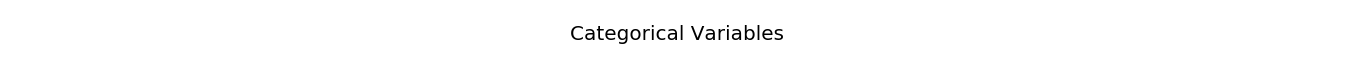

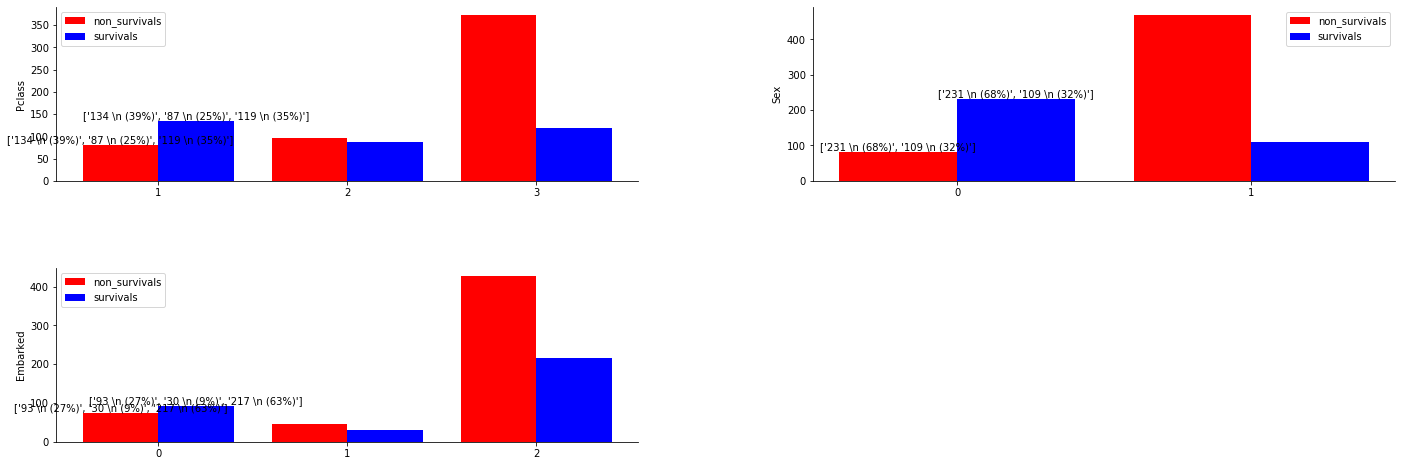

In [14]:
myplt = MyPlotter()
grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

fig_ttl = plt.figure(figsize=(12 * grd_cols_n, 1))
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables', fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(12 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

# data_class = df0['Pclass'].value_counts().to_frame().T
for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n0, n1])
        frc.append([fr0, fr1])

    df_freq = pd.DataFrame(freq, columns=['non_survivals', 'survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals', 'survivals'], index=data_cat[col].unique()).T

    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
#     print(labs0)
#     print(labs1)
    myplt.plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0, labs1],
                           plots_labels=['non_survivals', 'survivals'],
                           plots_colors=['r', 'b'],
                           legend_loc=0,
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})


#### First, lets look on non-survivels

     Survived  Pclass  Sex  Embarked
0           0       3    1         2
1           1       1    0         0
2           1       3    0         2
3           1       1    0         2
4           0       3    1         2
..        ...     ...  ...       ...
886         0       2    1         2
887         1       1    0         2
888         0       3    0         2
889         1       1    1         0
890         0       3    1         1

[889 rows x 4 columns]


Text(0.5, 0.98, 'Pair Plots')

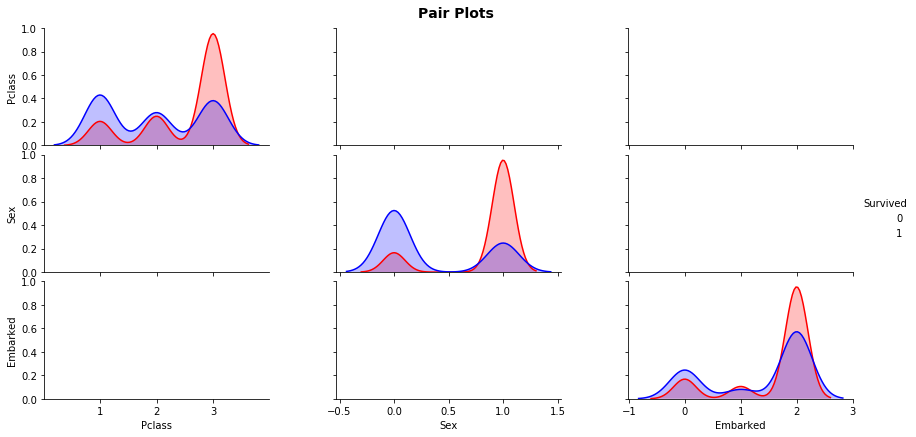

In [45]:
# fig_ttl = plt.figure(figsize=(12 * grd_cols_n, 1))
# ax0 = fig_ttl.add_subplot()
# ax0.text(0.5, 0.5, 'SURVIVALS', fontsize=20, horizontalalignment='center', verticalalignment='center')
# ax0.axis('off')
# fig = plt.figure()
print(pd.concat([data['Survived'], data_cat], axis=1))
pp = sns.pairplot(data=pd.concat([data['Survived'], data_cat], axis=1),
             hue='Survived', 
             hue_order=None, 
             palette={0:'r', 1:'b'}, 
             vars=None, 
             x_vars=None, 
             y_vars=None, 
             kind='auto', 
             diag_kind='kde', 
             markers=None, 
             height=2, 
             aspect=2, 
             corner=False, 
             dropna=True, 
             plot_kws = {'alpha':0.6, 's':10, 'edgecolor':'k', 'linewidth':0.5}, 
             diag_kws=None, 
             grid_kws=None)

# pp = pp.map_lower(sns.violinplot, alpha=0.6)
# pp = pp.map_upper(sns.scatterplot)

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Pair Plots', fontsize=14, fontweight='bold')
# ax=fig.add_subplot(grd)

# fig_ttl = plt.figure(figsize=(12 * grd_cols_n, 1))
# ax0 = fig_ttl.add_subplot()
# ax0.text(0.5, 0.5, 'NON-SURVIVALS', fontsize=20, horizontalalignment='center', verticalalignment='center')
# ax0.axis('off')
# sns.pairplot(data=df1[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']],
#              hue='Survived', 
#              hue_order=None, 
#              palette={1:'b'}, 
#              vars=None, 
#              x_vars=None, 
#              y_vars=None, 
#              kind='scatter', 
#              diag_kind='hist', 
#              markers=None, 
#              height=2, 
#              aspect=2, 
#              corner=True, 
#              dropna=True, 
#              plot_kws=None, 
#              diag_kws=None, 
#              grid_kws=None)

In [25]:
df0= data_train.loc[data_train['Survived']==0]

df1= data_train.loc[data_train['Survived']==1]

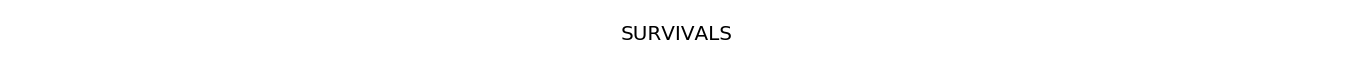

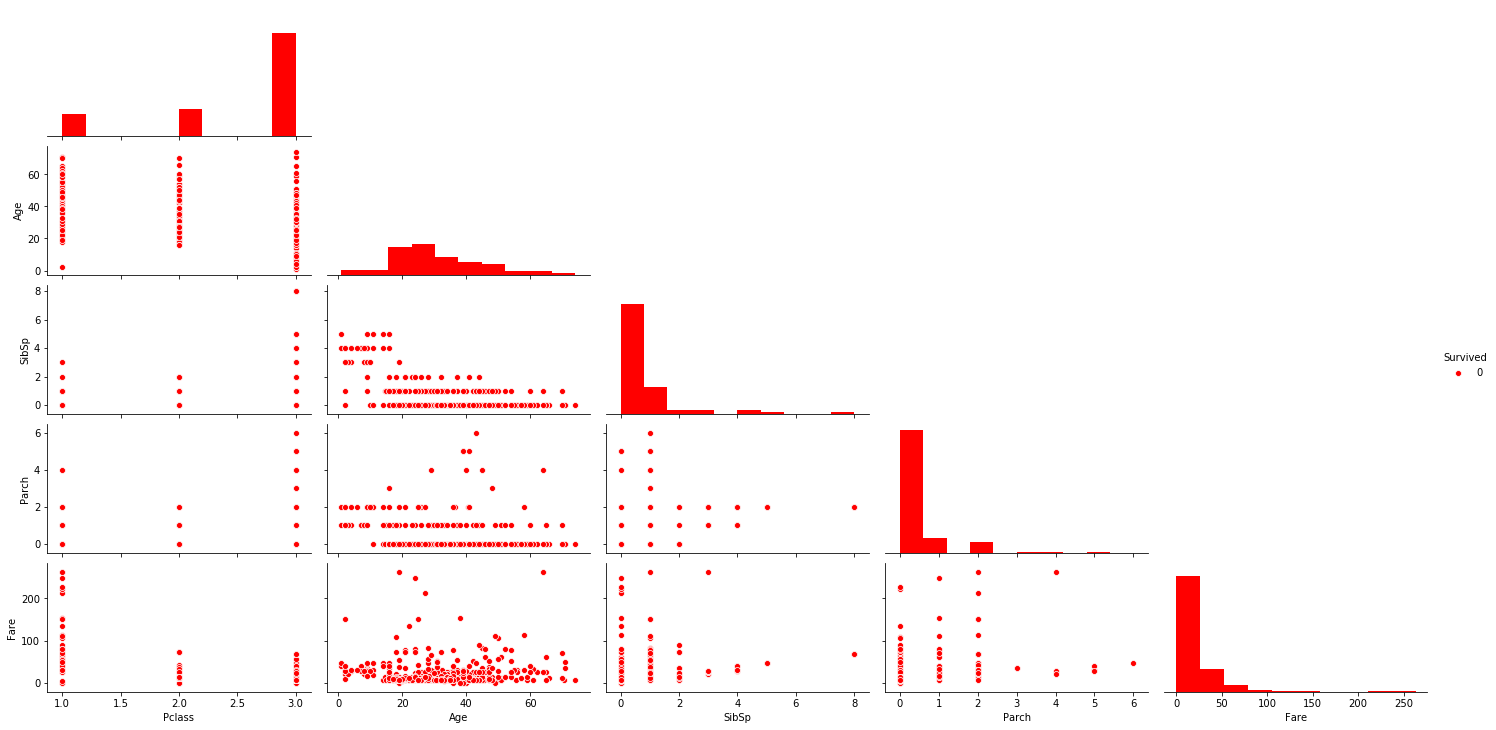

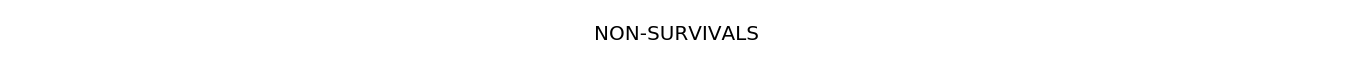

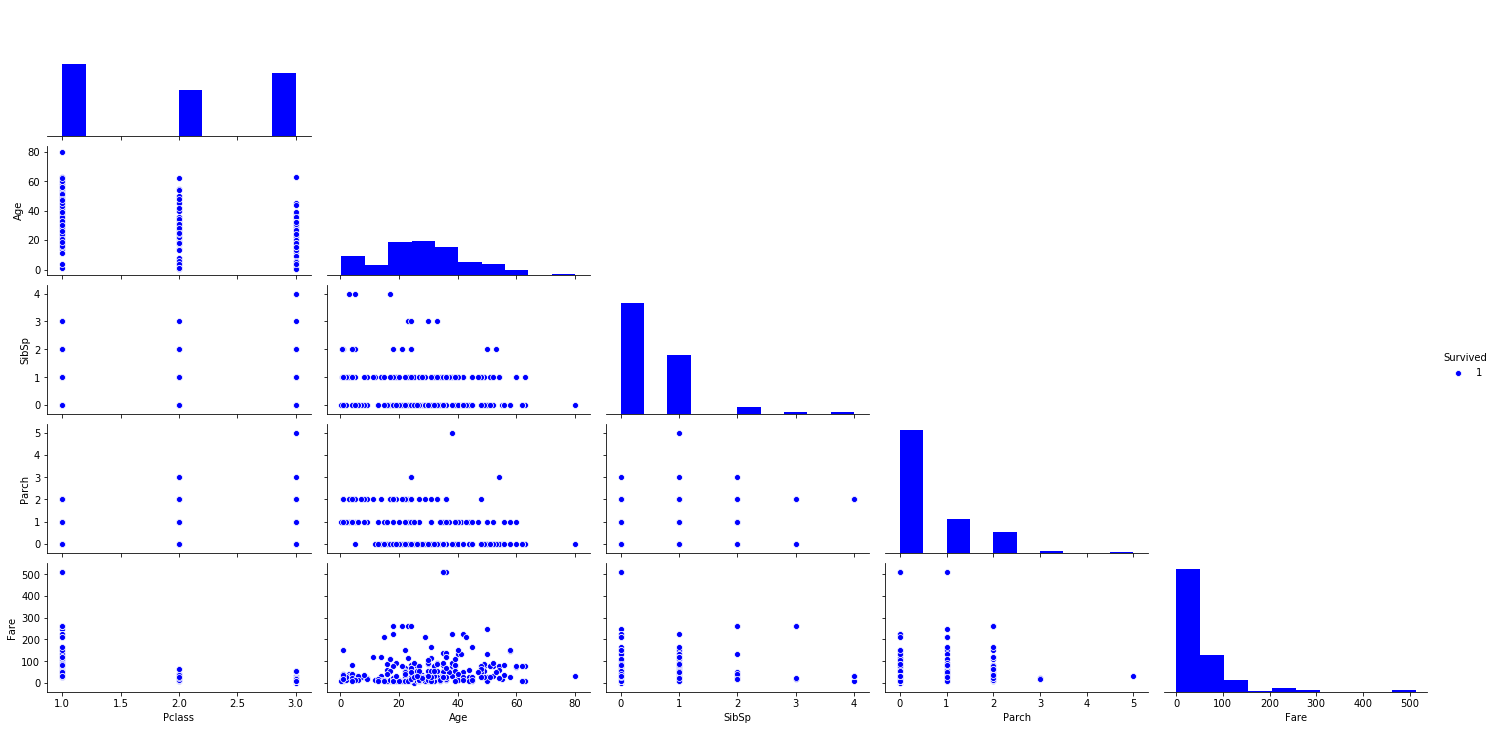

In [29]:
# fig_ttl = plt.figure(figsize=(12 * grd_cols_n, 1))
# ax0 = fig_ttl.add_subplot()
# ax0.text(0.5, 0.5, 'SURVIVALS', fontsize=20, horizontalalignment='center', verticalalignment='center')
# ax0.axis('off')
# fig = plt.figure()
sns.pairplot(data=df0[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']],
             hue='Survived', 
             hue_order=None, 
             palette={0:'r'}, 
             vars=None, 
             x_vars=None, 
             y_vars=None, 
             kind='scatter', 
             diag_kind='hist', 
             markers=None, 
             height=2, 
             aspect=2, 
             corner=True, 
             dropna=True, 
             plot_kws=None, 
             diag_kws=None, 
             grid_kws=None)
# ax=fig.add_subplot(grd)

fig_ttl = plt.figure(figsize=(12 * grd_cols_n, 1))
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'NON-SURVIVALS', fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')
sns.pairplot(data=df1[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']],
             hue='Survived', 
             hue_order=None, 
             palette={1:'b'}, 
             vars=None, 
             x_vars=None, 
             y_vars=None, 
             kind='scatter', 
             diag_kind='hist', 
             markers=None, 
             height=2, 
             aspect=2, 
             corner=True, 
             dropna=True, 
             plot_kws=None, 
             diag_kws=None, 
             grid_kws=None)

#### Notes:

##### Diagonal
* 3rd is more likely to die. (same for ticket Fare)
* Mean Age is between 20 & 30 y (will do a closer look later)
* SibSp & Parch do not tell much. It shows that singles are more likely to die but the najority of passengers were singles probably. (will do a closer look later)

Text(0.5, 1.07, 'Skewness = 0.584 \n Kurtosis = 0.265')

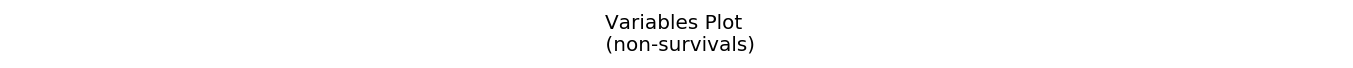

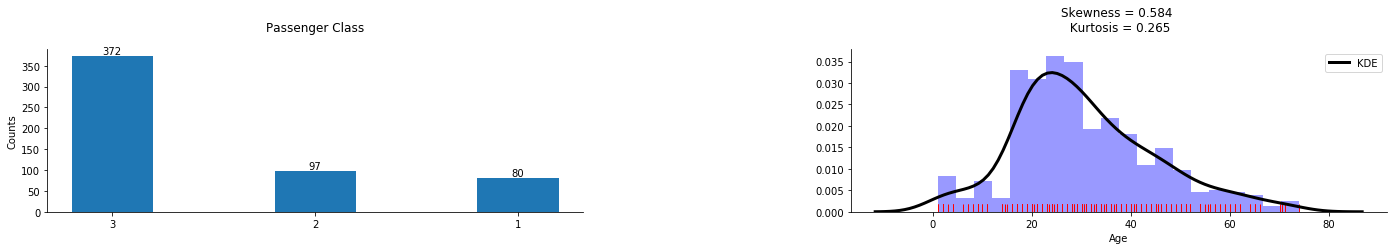

In [23]:
myplt = MyPlotter()
grd = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

fig_ttl = plt.figure(figsize=(12 * grd_cols_n, 1))
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Variables Plot \n (non-survivals)', fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(12 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.5, hspace=0.5)

data_class = df0['Pclass'].value_counts().to_frame().T
myplt.plot_bar_diagram(ax=fig.add_subplot(gs[0]),
                           data=data_class,
                           bar_labels=[['{0:d}'.format(i) for i in data_class.values[0]]],
                           title='Passenger Class',
                           length_label='Counts',
                           orient='v',
                           spines={'top': False, 'right': False})


ax = fig.add_subplot(gs[1])
data = df0['Age'].dropna()
sns.distplot(data, bins=20, kde=True, norm_hist=False, rug=True, 
             rug_kws={'color':'r'},
             kde_kws={'color':'k', 'lw':3, 'label':'KDE'},
             hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

skewness = '{0:.3f}'.format(sts.skew(data.values))
kurtosis = '{0:.3f}'.format(sts.kurtosis(data.values))
ttl = ax.title
ttl.set_position([.5, 1.07])
ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))

# ax1 = fig.add_subplot(gs[2])
# # data1 = data.apply(np.log)
# scaler = StandardScaler()
# normalizer = Normalizer()
# data1 = data.values
# # data1 = scaler.fit_transform(data1.reshape(-1,1))
# # data1 = normalizer.fit_transform(data1.reshape(1,-1))
# data1 = np.log(data1)

# # print(data1)
# sns.distplot(data1, bins=20, kde=True, norm_hist=False, rug=True, 
#              rug_kws={'color':'r'},
#              kde_kws={'color':'k', 'lw':3, 'label':'KDE'},
#              hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)

# skewness = '{0:.3f}'.format(sts.skew(data1))
# kurtosis = '{0:.3f}'.format(sts.kurtosis(data1))
# ttl = ax1.title
# ttl.set_position([.5, 1.07])
# ax1.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))

# #number of kids <= 8 y/o
# print('Children <= 8 y/o: {0}'.format(len(df0.loc[df0['Age'] <= 12].index)))

# ax2 = fig.add_subplot(gs[3])
# # data1 = data.apply(np.log)
# # scaler = StandardScaler()
# # normalizer = Normalizer()
# data2 = data.loc[data > 12].values
# # data1 = scaler.fit_transform(data1.reshape(-1,1))
# # data1 = normalizer.fit_transform(data1.reshape(1,-1))
# data2 = np.log(data2)

# # print(data1)
# sns.distplot(data2, bins=20, kde=True, norm_hist=False, rug=True, 
#              rug_kws={'color':'r'},
#              kde_kws={'color':'k', 'lw':3, 'label':'KDE'},
#              hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)

# skewness = '{0:.3f}'.format(sts.skew(data2))
# kurtosis = '{0:.3f}'.format(sts.kurtosis(data2))
# ttl = ax2.title
# ttl.set_position([.5, 1.07])
# ax2.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r